Création d'un système de recommandation d'image pour les articles d'actualité à l'aide de l'intégration de mots

In [1]:
# loading libraries
import pandas as pd
import numpy as np
import json
import csv
import time

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# python version
#import platform
#print(f'Python version {platform.python_version()}') # should be 3.7. ours was 3.7.4

# tensorflow
import tensorflow as tf
print(f'Tensorflow version {tf.__version__}') # should be 2.0.0 or greater
import tensorflow_hub as hub

# wordcloud
from wordcloud import WordCloud, STOPWORDS


Tensorflow version 2.4.0


In [12]:
pip install tensorflow_hub

Note: you may need to restart the kernel to use updated packages.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [14]:
# test chargement de toutes les données

with open('../data/captioning_dataset.json') as json_file:
    fulldata = json.load(json_file)

In [ ]:
# tesr visualisation des données textuelles
fulldata["584f1ddf95d0e0392607597e"]

In [2]:
# Chargement données textuelles

with open('../data/captioning_dataset_part1.json') as json_file:
    data = json.load(json_file)

In [3]:
__ids = [k for k,v in data.items()]
print(__ids[:10])

['584f1ddf95d0e0392607597e', '54453eab38f0d832c813e7f5', '5a57160395d0e0110c1a3f23', '55b40f6b38f0d851b1f6dc7c', '51a92bb440e9ec65d203a9e4', '56562fe138f0d8310210dcbc', '58f7352c95d0e024b586c1c3', '5397a3d038f0d80b34dcbdd6', '549474a738f0d87118e48f39', '5812248995d0e022439c592f']


In [4]:
data["5812248995d0e022439c592f"]

{'images': {'0': 'A meat sampler at Bonnie Blue in Winchester, Va.'},
 'headline': {'main': '13 Essential Barbecue Stops (and What to Order)',
  'kicker': 'Pursuits'},
 'abstract': None,
 'article_url': 'https://www.nytimes.com/2016/10/30/travel/13-essential-barbecue-bbq-stops.html',
 'article': "If you're near Harrisburg, make a pit stop for sandwiches at the well-hidden ShakeDown BBQ (668 Firehouse Road, Grantville, Pa.; shakedownbbq.com). The menu changes regularly, but the sausage is always good. It is open all day Friday and Saturday and for lunch only on Thursday and Sunday.\n\nIf you're out on a Thursday, try the weekly special at Hempen Hill BBQ (13208 Fountain Head Plaza, Hagerstown, Md.; hempenhillbbq.com). If not, both the chicken and the sausage are fabulous. The crab chips, expansive beer selection and big screens can draw a crowd if a game is on.\n\nBonnie Blue Southern Market & Bakery (334 West Boscawen Street, Winchester, Va.; bonnieblue.us) puts out a stellar sausage g

In [66]:
type(data)

dict

In [5]:
min_words = 5
ids, headlines, urls, all_images, articles, lens = [], [], [], [], [], []

for i,idx in enumerate(data):
    try:
        headline = data[idx]['headline']['main'].strip()
        num_words = len(headline.split(' '))
        
        # removing article headlines if the number of words in the headline is less than 5
        if num_words < min_words:
            continue

        headlines.append(headline)
        lens.append(num_words)
        all_images.append(data[idx]['images'])
        urls.append(data[idx]['article_url'])
        articles.append(data[idx]['article'])
        ids.append(idx)
    
    # deals with situations where articles are missing a headline
    except:
        continue

# creating a dataframe with our results
article_df = pd.DataFrame({'idx': ids, 'headline': headlines, 'text': articles, 'url': urls, 'num_words': lens})
print(f'Number of Articles: {article_df.shape[0]}')
article_df.head()


Number of Articles: 143727


idx  \
0  584f1ddf95d0e0392607597e   
1  54453eab38f0d832c813e7f5   
2  5a57160395d0e0110c1a3f23   
3  55b40f6b38f0d851b1f6dc7c   
4  51a92bb440e9ec65d203a9e4   

                                            headline  \
0  Rodrigo Duterte Criticizes Times Coverage of P...   
1                Facebook Seeps Onto Other Web Sites   
2            A Beginner’s Guide to Backing Up Photos   
3  Black South Carolina Trooper Explains Why He H...   
4               The Right Way to Do the Hillary Step   

                                                text  \
0  His article reported that since the beginning ...   
1  The moves by Facebook and its rivals set up a ...   
2  Both Amazon Prime Photos and Dropbox have thei...   
3  A different sort of photograph had helped to e...   
4  KETCHUM, Idaho -- SIXTY years ago this week, a...   

                                                 url  num_words  
0  https://www.nytimes.com/2016/12/12/world/asia/...          9  
1  https://www.nytimes.com/2010/04/19/technology/...          6  
2  https://www.nytimes.com/2018/01/11/smarter-liv...          7  
3  https://www.nytimes.com/2015/07/26/us/black-so...         11  
4  https://www.nytimes.com/2013/06/01/opinion/the...          8

In [7]:
img_captions, img_article_ids, caption_lens, nums = [], [], [], []

for i, img in enumerate(all_images):
    for k in img.keys():
        caption = img[k].strip()
        num_words = len(caption.split(' '))
        
        # removing article headlines if the number of words in the headline is less than 5
        if num_words < min_words:
            continue
        
        nums.append(k)
        img_captions.append(caption)
        caption_lens.append(num_words)
        img_article_ids.append(ids[i])
        
# creating a dataframe with our results        
image_df = pd.DataFrame({'article_idx': img_article_ids, 'caption': img_captions, 
                         'num_words': caption_lens, 'number': nums})
print(f'Number of Images: {image_df.shape[0]}')
image_df.head()

Number of Images: 224160


article_idx  \
0  584f1ddf95d0e0392607597e   
1  584f1ddf95d0e0392607597e   
2  584f1ddf95d0e0392607597e   
3  584f1ddf95d0e0392607597e   
4  54453eab38f0d832c813e7f5   

                                             caption  num_words number  
0  A woman grieved as she waited for the body of ...         27      1  
1  The body of a man killed by unknown gunmen lay...         16      0  
2  The funeral of Jimboy Bolasa, 25, who was foun...         14      3  
3  The body of a man killed by unidentified gunme...         16      2  
4  Mark Zuckerberg is the chief executive of Face...          8      0

1.795535192201405


Text(0.5, 1.0, 'Words per image caption')

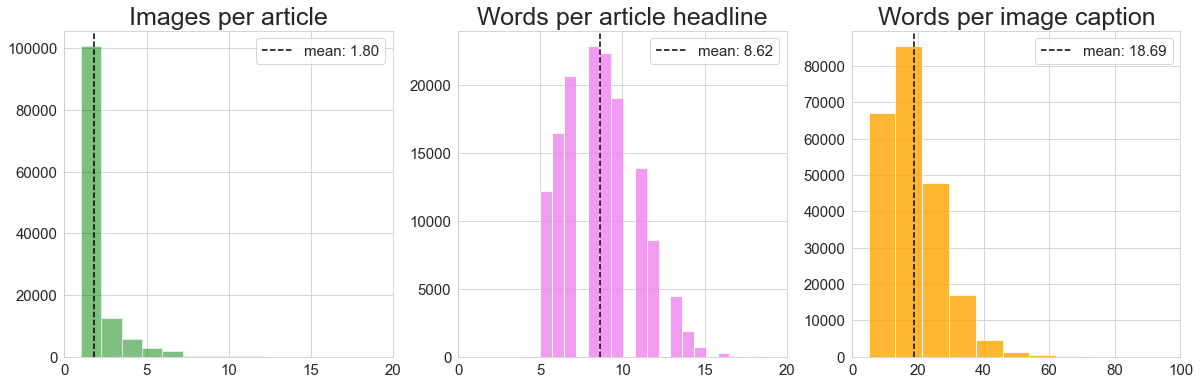

In [11]:
# EDA

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,6))

# plotting constants
bins = 25
colors = ['green', 'violet', 'orange']
alphas = [0.5, 0.8, 0.8]
fontsize = 25
medfont = 15
lc = 'black'
ls = '--'

# images per article
nums = image_df.groupby('article_idx').count()['caption'].values
ax[0].hist(nums, bins=bins, color=colors[0], alpha=alphas[0])
ax[0].axvline(np.mean(nums), label=f'mean: {np.mean(nums):.2f}', color=lc, linestyle=ls)
ax[0].legend(fontsize=medfont)
ax[0].set_xlim(0,20)
ax[0].tick_params(axis = 'both', which = 'major', labelsize = medfont)
ax[0].set_title(f'Images per article', fontsize=fontsize)

# num words per article headline
headline_words = article_df['num_words'].values
ax[1].hist(headline_words, bins=bins, color=colors[1], alpha=alphas[1])
ax[1].axvline(np.mean(headline_words), label=f'mean: {np.mean(headline_words):.2f}', color=lc, linestyle=ls)
ax[1].legend(fontsize=medfont)
ax[1].set_xlim(0,20)
ax[1].tick_params(axis = 'both', which = 'major', labelsize = medfont)
ax[1].set_title(f'Words per article headline', fontsize=fontsize)

# num words per image caption
caption_words = image_df['num_words'].values
ax[2].hist(caption_words, bins=bins, color=colors[2], alpha=alphas[2])
ax[2].axvline(np.mean(caption_words), label=f'mean: {np.mean(caption_words):.2f}', color=lc, linestyle=ls)
ax[2].legend(fontsize=medfont)
ax[2].set_xlim(0,100)
ax[2].tick_params(axis = 'both', which = 'major', labelsize = medfont)
ax[2].set_title(f'Words per image caption', fontsize=fontsize)


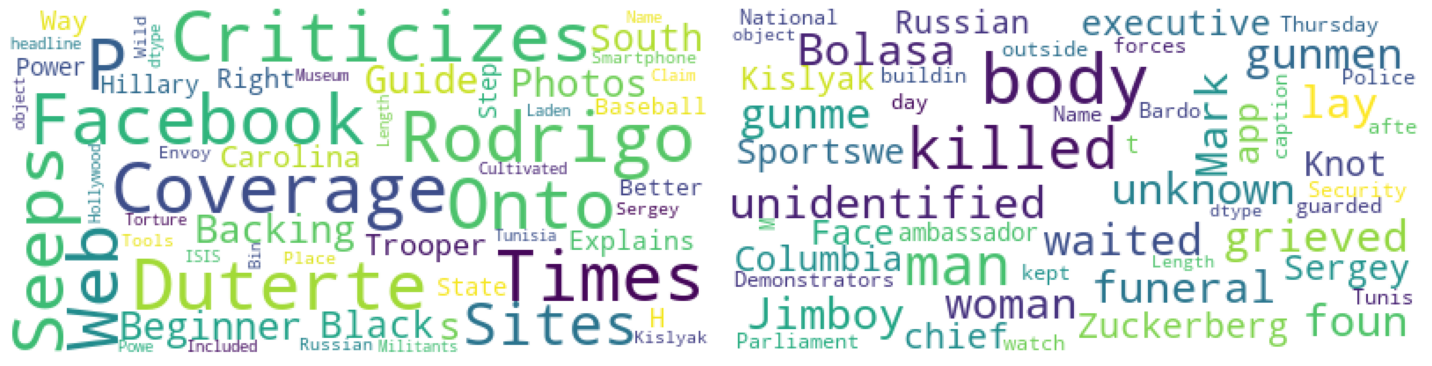

In [16]:
stopwords = set(STOPWORDS)
cloud = WordCloud(background_color='white', stopwords=stopwords, random_state=200, max_font_size=40)

fig, ax = plt.subplots(ncols=2, figsize=(20,20))
ax[0].set_axis_off()
wordcloud_article = cloud.generate(str(article_df['headline']))
ax[0].imshow(wordcloud_article)

ax[1].set_axis_off()
wordcloud_image = cloud.generate(str(image_df['caption']))
ax[1].imshow(wordcloud_image)

fig.tight_layout()

### GloVe Word Embeddings

In [13]:
# loading glove data file
# # URL to donwload the GloVe embedding: https://nlp.stanford.edu/projects/glove/
D = 50
glove_data_file = f'../data/glove.6B/glove.6B.{D}d.txt'
words = pd.read_csv(glove_data_file, sep=" ", index_col=0, header=None, quoting=csv.QUOTE_NONE)

# creating a dictionary for accessing words quickly
words_dict = {word: embed for word, embed in zip(words.index, words.values.tolist())}
print(f'Loaded {len(words_dict.keys())} words from the GloVe file')

Loaded 399998 words from the GloVe file


In [21]:
def vec(w, D=50):
    """
    Converts a word to an embedding vector
    """
    try:
        return np.array(words_dict[w])
    # if the word is not in our vocabulary, we return zeros
    except:
        return np.zeros(D)

def average_embedding(sentence, D=50):
    """
    Computes the average embedding of a sentence
    """
    total_embeddings = np.zeros(D)
    num_words = len(sentence.split())
    
    # a sanity check
    if num_words == 0:
        return total_embeddings
    
    # getting the embedding for each word
    for word in sentence.split():
        emb = vec(word)
        total_embeddings += emb
        
    # averaging the embeddings
    avg_embeddings = total_embeddings/num_words
    
    # so that we are not dividing by zero
    if np.linalg.norm(avg_embeddings) > 1e-10:
        return avg_embeddings/np.linalg.norm(avg_embeddings)
    else:
        return avg_embeddings

def preprocessing(sentence):
    """
    Preprocessing. Removes punctuation and stop words
    """
    # removing extra whitespace and making the sentence lower case
    sentence = sentence.lower().strip()
    
    # removing punctuation
    bad_chars = '-.?;,!@#$%^&*()+/{}[]\\":\'“’'
    for char in bad_chars:
        sentence = sentence.replace(char, ' ').strip()
    all_words = sentence.split()
    
    # removing stop words
    filtered_sentence = [w for w in all_words if not w in stopwords]
    return ' '.join(filtered_sentence)

In [22]:
# image embeddings
start_time = time.time()

# saving the embeddings for all the image captions to a numpy array
image_embeddings = np.zeros(shape=(len(image_df), D))
for i, text in enumerate(image_df.caption.values):
    if i % 100000 == 0 and i > 0:
        print(f'{i} out of {len(image_df.caption.values)} done in {time.time() - start_time:.2f}s')
    text_prep = preprocessing(text)
    emb = average_embedding(text_prep)
    image_embeddings[i] = average_embedding(text_prep)
print(f'{i} out of {len(image_df.caption.values)} done in {time.time() - start_time:.2f}s')

100000 out of 224160 done in 17.47s
200000 out of 224160 done in 35.13s
224159 out of 224160 done in 39.82s


### Universal Sentence Encoder 

In [23]:
# load pretrained USE

try:
  # if hub.load() fails, download is avaliable directly from url
    use_encoder = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
except:
  # download model from website
  # load model from directory if hub load fails on link
    use_encoder = hub.load('USE/')

# embed sentence
example = 'this should output a sentence embedding of 1 x 512'
example_embedding = use_encoder([example])
  
print(example_embedding.shape)

(1, 512)


In [24]:
use_encoder

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x15929abe488>

In [25]:
start_time = time.time()

# saving the use embeddings for all the image captions to a numpy array
use_img_embedding = np.zeros((len(image_df),512))
for i, text in enumerate(image_df.caption.values):
    if i % 100000 == 0 and i > 0:
        print(f'{i} out of {len(image_df.caption.values)} done in {time.time() - start_time:.2f}s')
    emb = use_encoder([text])
    use_img_embedding[i] = emb
print(f'{i} out of {len(image_df.caption.values)} done')

# normalize embeddings
use_img_embedding_normalized = use_img_embedding/np.linalg.norm(use_img_embedding,axis=1).reshape(-1,1)

100000 out of 224160 done in 277.59s
200000 out of 224160 done in 564.66s
224159 out of 224160 done


In [26]:
# Predictions and Results

# Predictions and Results

def predict_glove_images(headline, k=2):
    """
    Predicts the closest matching image caption given an article headline
    Returns a list of image ids
    """
    # pre-processes the headline
    text_prep = preprocessing(headline)
    
    # finding the average embedding for the headline
    emb = average_embedding(text_prep)
    
    # normalizing the embeddings
    emb = emb.reshape(-1,1)/np.linalg.norm(emb)
    
    # calculating the cosine distance. 
    # since the embeddings are normalized: this is the dot product of the embedding vector and the matrix
    scores_images = np.dot(image_embeddings, emb).flatten()
    
    # predict top k images
    
    top_k_images = image_df.iloc[np.argsort(-scores_images)[:k]]
    return top_k_images

def predict_use_images(headline, k=2):
    """
    Predicts the closest matching image caption given an article headline
    Returns a list of image ids
    """
    # finding the embedding. No pre-processing is needed
    emb = use_encoder([headline])
    
    # normalizing the embeddings
    emb = emb/np.linalg.norm(emb)
    
    # calculating the cosine distance. 
    # since the embeddings are normalized: this is the dot product of the embedding vector and the matrix
    scores_images = np.dot(emb,use_img_embedding.T).flatten()
    
    # predict top k images
    top_k_images = image_df.iloc[np.argsort(-scores_images)[:k]]
    return top_k_images

In [27]:
k = 2
ind = 97043 # np.random.randint(0, len(article_df)) # 97043
article = article_df.iloc[ind]
article_id = article['idx']
headline = article['headline']
url = article['url']

print(f'Article id: {article_id}, headline: {headline}')
print(f'Url: {url}')

Article id: 56c460d038f0d82fc3a19bcd, headline: Reinvention in Walla Walla’s Wine Country
Url: https://www.nytimes.com/2016/02/21/travel/walla-walla-wineries-restaurants.html


GloVe Predictions


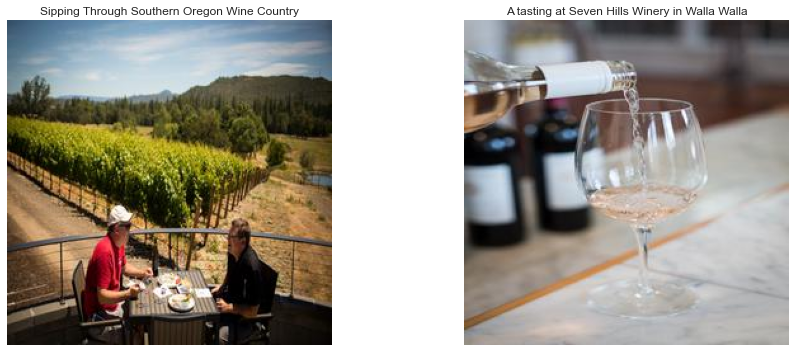

In [29]:
# glove predictions
results_glove = predict_glove_images(headline, 2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
idx = results_glove.article_idx.values
captions = results_glove.caption.values
nums = results_glove.number.values

print('GloVe Predictions')
for i in range(k):
    # Chargement des images 

    img = plt.imread(f'../data/resized/{idx[i]}_{nums[i]}.jpg')
    ax[i].imshow(img)
    ax[i].set_axis_off()
    ax[i].set_title(captions[i])
fig.tight_layout()

USE Predictions


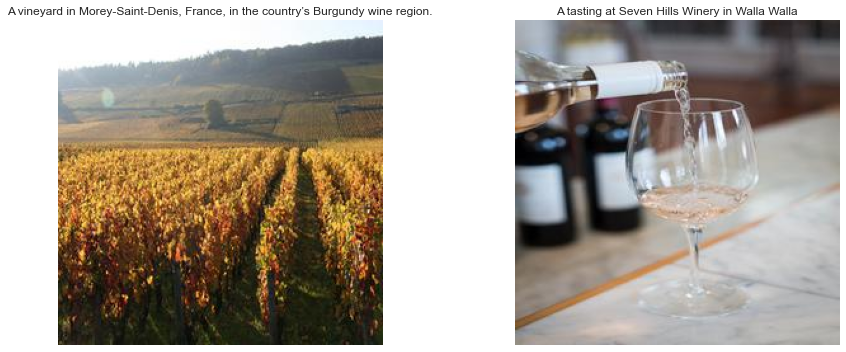

In [31]:
# use predictions
results_use = predict_use_images(headline, 2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
idx = results_use.article_idx.values
captions = results_use.caption.values
nums = results_use.number.values

print('USE Predictions')
for i in range(k):
    img = plt.imread(f'../data/resized/{idx[i]}_{nums[i]}.jpg')
    ax[i].imshow(img)
    ax[i].set_axis_off()
    ax[i].set_title(captions[i])
fig.tight_layout()

### Test recommandation d'images sur un nouvel article

In [29]:
k = 2
ind = np.random.randint(0, len(article_df))
article = article_df.iloc[ind]
article_id = article['idx']
headline = article['headline']
url = article['url']

print(f'Article id: {article_id}, headline: {headline}')
print(f'Url: {url}')

Article id: 54ea57d738f0d856c47f2b50, headline: Review: ‘Belladonna,’ a Poisonous Duet at the 92nd Street Y
Url: https://www.nytimes.com/2015/02/23/arts/dance/review-belladonna-a-poisonous-duet-at-the-92nd-street-y.html


GloVe Predictions


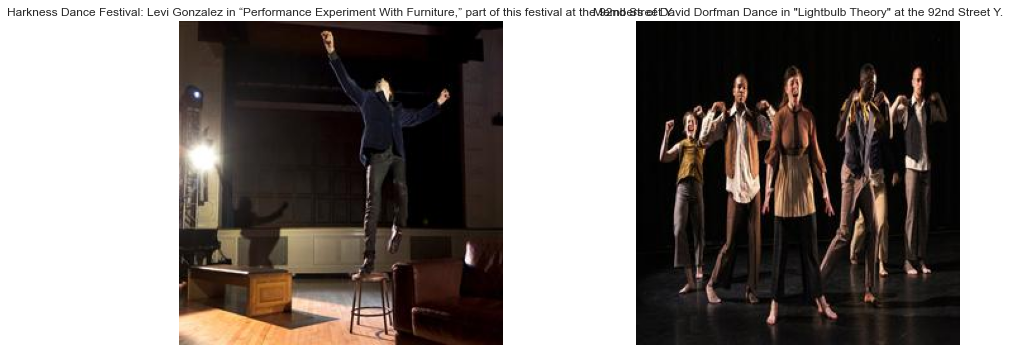

In [32]:
# glove predictions
results_glove = predict_glove_images(headline, 2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
idx = results_glove.article_idx.values
captions = results_glove.caption.values
nums = results_glove.number.values

print('GloVe Predictions')
for i in range(k):
    # Chargement des images 

    img = plt.imread(f'../data/resized.tar/resized/{idx[i]}_{nums[i]}.jpg')
    ax[i].imshow(img)
    ax[i].set_axis_off()
    ax[i].set_title(captions[i])
fig.tight_layout()

USE Predictions


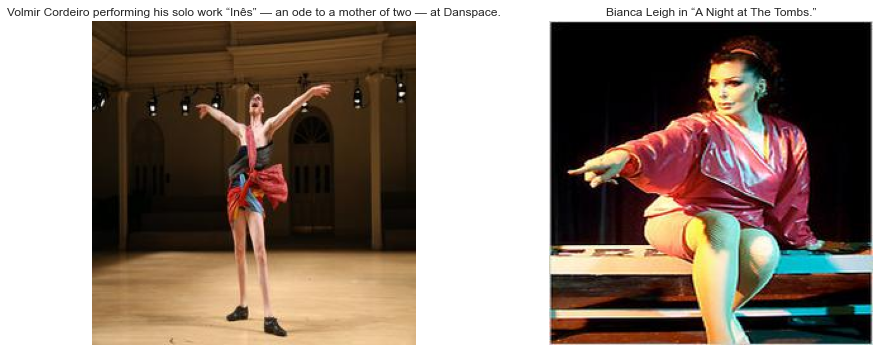

In [33]:
# use predictions
results_use = predict_use_images(headline, 2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
idx = results_use.article_idx.values
captions = results_use.caption.values
nums = results_use.number.values

print('USE Predictions')
for i in range(k):
    img = plt.imread(f'../data/resized.tar/resized/{idx[i]}_{nums[i]}.jpg')
    ax[i].imshow(img)
    ax[i].set_axis_off()
    ax[i].set_title(captions[i])
fig.tight_layout()

### Test avec plus d'images recommandées sur un nouvel article

In [71]:
# Predictions and Results

# Predictions and Results

def predict_glove_images5(headline, k=2):
    """
    Predicts the closest matching image caption given an article headline
    Returns a list of image ids
    """
    # pre-processes the headline
    text_prep = preprocessing(headline)
    
    # finding the average embedding for the headline
    emb = average_embedding(text_prep)
    
    # normalizing the embeddings
    emb = emb.reshape(-1,1)/np.linalg.norm(emb)
    
    # calculating the cosine distance. 
    # since the embeddings are normalized: this is the dot product of the embedding vector and the matrix
    scores_images = np.dot(image_embeddings, emb).flatten()
    
    # predict top k images
    print("k",k )
    print("len(image_df)", len(image_df))
    print("len:", len(np.argsort(-scores_images)))
    top_k_images = image_df.iloc[np.argsort(-scores_images)[:k]]
    return top_k_images

def predict_use_images5(headline, k=2):
    """
    Predicts the closest matching image caption given an article headline
    Returns a list of image ids
    """
    # finding the embedding. No pre-processing is needed
    emb = use_encoder([headline])
    
    # normalizing the embeddings
    emb = emb/np.linalg.norm(emb)
    
    # calculating the cosine distance. 
    # since the embeddings are normalized: this is the dot product of the embedding vector and the matrix
    scores_images = np.dot(emb,use_img_embedding.T).flatten()
    
    # predict top k images
    top_k_images = image_df.iloc[np.argsort(-scores_images)[:k]]
    return top_k_images

In [51]:
k = 2
ind = np.random.randint(0, len(article_df))
article = article_df.iloc[ind]
article_id = article['idx']
headline = article['headline']
url = article['url']

print(f'Article id: {article_id}, headline: {headline}')
print(f'Url: {url}')

Article id: 52fd483a38f0d8191ccb85a3, headline: Pieces That Invite a Closer Look
Url: https://www.nytimes.com/2014/02/16/nyregion/a-review-of-shock-u-mentaries-at-the-islip-art-museum.html


GloVe Predictions


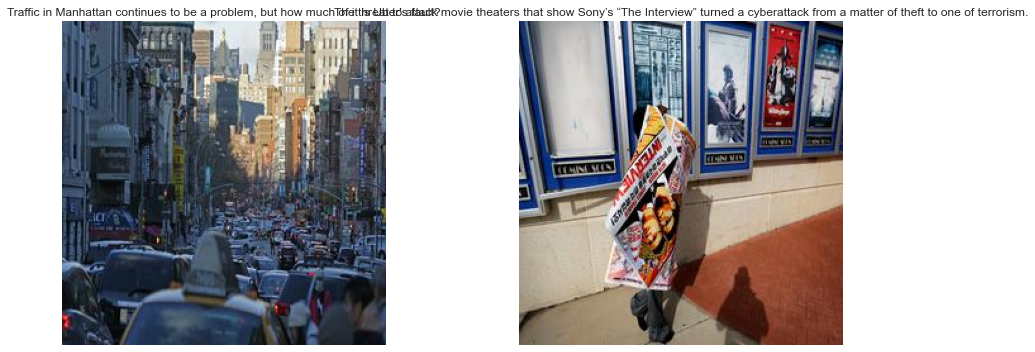

In [54]:
# glove predictions
results_glove = predict_glove_images5("Trump fights for a job that he's not doing as coronavirus rages", 2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
idx = results_glove.article_idx.values
captions = results_glove.caption.values
nums = results_glove.number.values

print('GloVe Predictions')
for i in range(k):
    # Chargement des images 

    img = plt.imread(f'../data/resized.tar/resized/{idx[i]}_{nums[i]}.jpg')
    ax[i].imshow(img)
    ax[i].set_axis_off()
    ax[i].set_title(captions[i])
fig.tight_layout()

USE Predictions


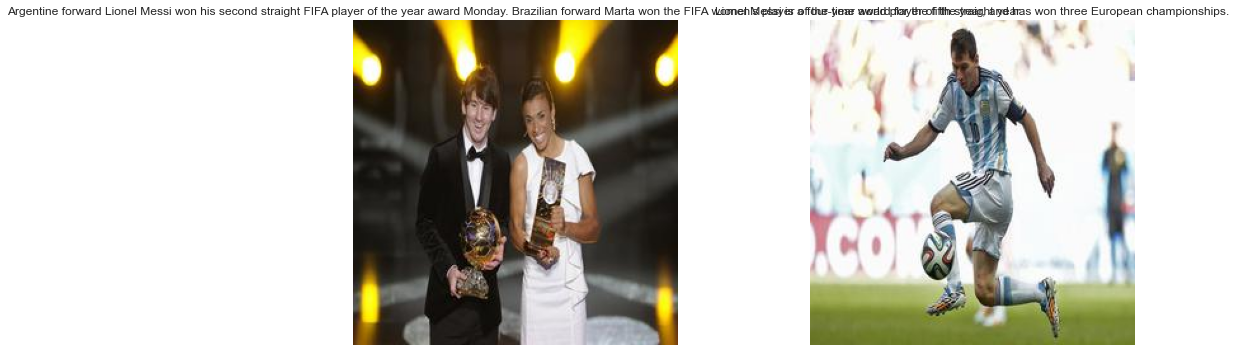

In [55]:
# test avec titre pris sur site cnn 
# use predictions

results_use = predict_use_images("Robert Lewandowski and Lucy Bronze named players of the year at the Best FIFA Football Awards", 2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
idx = results_use.article_idx.values
captions = results_use.caption.values
nums = results_use.number.values

print('USE Predictions')
for i in range(k):
    img = plt.imread(f'../data/resized.tar/resized/{idx[i]}_{nums[i]}.jpg')
    ax[i].imshow(img)
    ax[i].set_axis_off()
    ax[i].set_title(captions[i])
fig.tight_layout()

USE Predictions


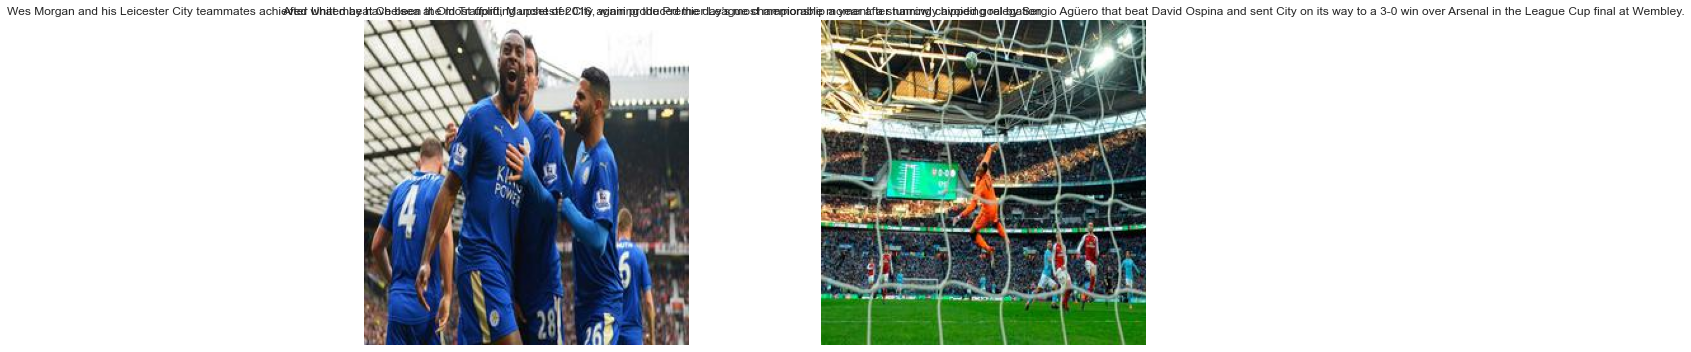

In [61]:
# test avec extrait d'articles sur site cnn

# use predictions

body = "I will remember this moment. Manchester City's Bronze was named the best women's player of the year, becoming the first defender to do so. Bronze won the league title, domestic cup and Champions League with Lyon last year before moving back to England at the start of the new season. The England international beat Chelsea's Pernille Harder and Lyon's Wendie Renard to the prize. What a surprise. To even be nominated alongside the two other players, they are both incredible players and outstanding human beings well, Bronze said over video call. I don't think I have the words right now to explain how I am feeling. If there is anything 2020 has taught us it is to appreciate every moment you have, never look too far ahead and live in the hear and now, she said. I will appreciate winning this award now more than ever, and I will remember this moment for the rest of my life."

results_use = predict_use_images(body, 2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
idx = results_use.article_idx.values
captions = results_use.caption.values
nums = results_use.number.values

print('USE Predictions')
for i in range(k):
    img = plt.imread(f'../data/resized.tar/resized/{idx[i]}_{nums[i]}.jpg')
    ax[i].imshow(img)
    ax[i].set_axis_off()
    ax[i].set_title(captions[i])
fig.tight_layout()

len: 223886
GloVe Predictions


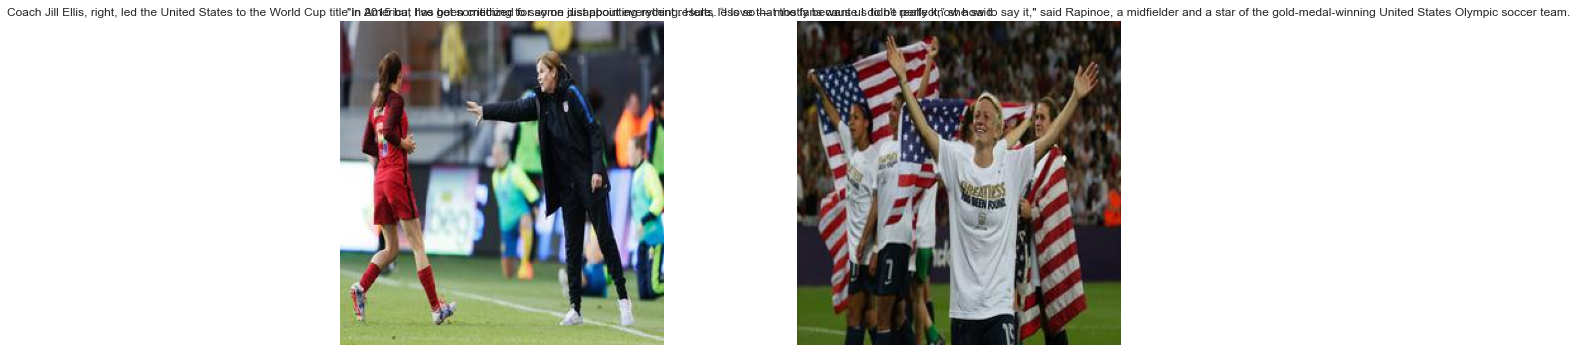

In [62]:
# glove predictions

body = "I will remember this moment. Manchester City's Bronze was named the best women's player of the year, becoming the first defender to do so. Bronze won the league title, domestic cup and Champions League with Lyon last year before moving back to England at the start of the new season. The England international beat Chelsea's Pernille Harder and Lyon's Wendie Renard to the prize. What a surprise. To even be nominated alongside the two other players, they are both incredible players and outstanding human beings well, Bronze said over video call. I don't think I have the words right now to explain how I am feeling. If there is anything 2020 has taught us it is to appreciate every moment you have, never look too far ahead and live in the hear and now, she said. I will appreciate winning this award now more than ever, and I will remember this moment for the rest of my life."


results_glove = predict_glove_images5(body, 2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
idx = results_glove.article_idx.values
captions = results_glove.caption.values
nums = results_glove.number.values

print('GloVe Predictions')
for i in range(k):
    # Chargement des images 

    img = plt.imread(f'../data/resized.tar/resized/{idx[i]}_{nums[i]}.jpg')
    ax[i].imshow(img)
    ax[i].set_axis_off()
    ax[i].set_title(captions[i])
fig.tight_layout()

k 5
len(image_df) 223886
len: 223886
GloVe Predictions


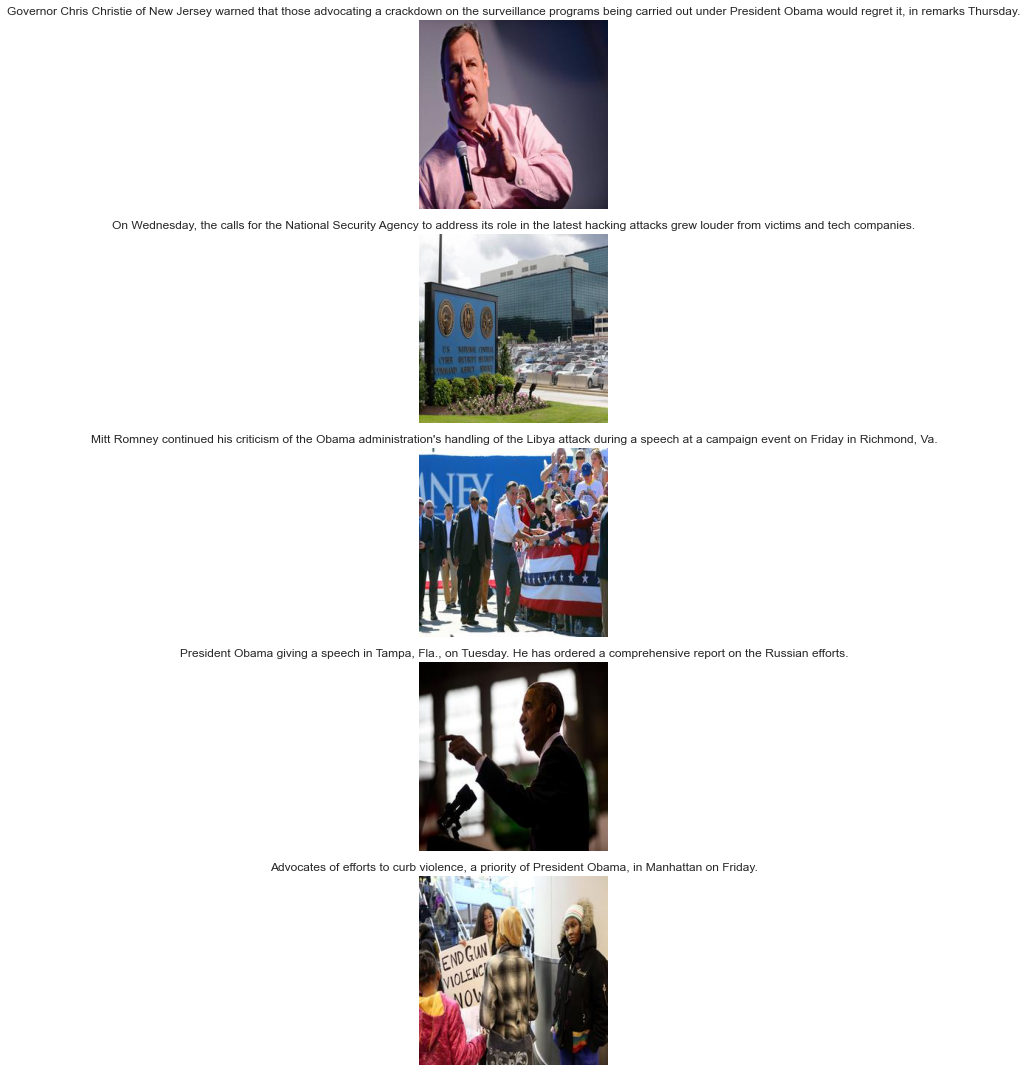

In [81]:
# glove predictions
k_result = 5
results_glove = predict_glove_images5('Philippines President Criticizes Times Coverage of Deadly Antidrug Campaign', k_result)

fig, ax = plt.subplots(nrows=k_result, ncols=1, figsize=(20,15))
idx = results_glove.article_idx.values
captions = results_glove.caption.values
nums = results_glove.number.values

print('GloVe Predictions')
for i in range(k_result):
    # Chargement des images 

    img = plt.imread(f'../data/resized.tar/resized/{idx[i]}_{nums[i]}.jpg')
    ax[i].imshow(img)
    ax[i].set_axis_off()
    ax[i].set_title(captions[i])
fig.tight_layout()

USE Predictions


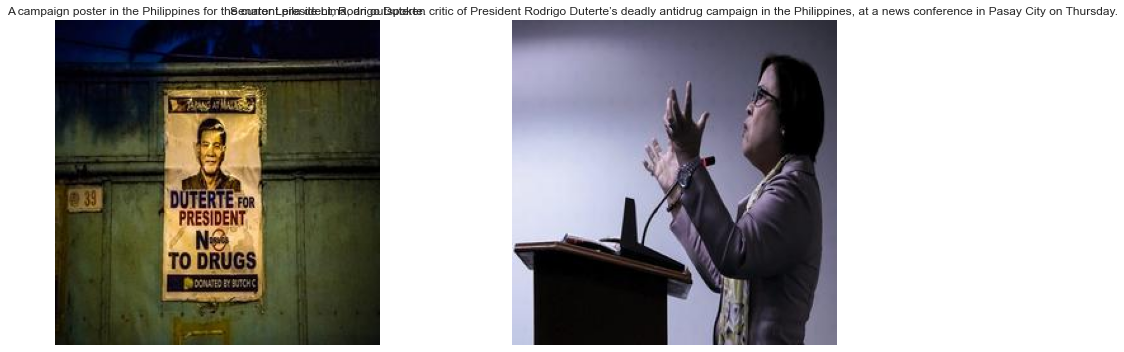

In [75]:
# test avec extrait d'articles sur site cnn

# use predictions

results_use = predict_use_images('Philippines President Criticizes Times Coverage of Deadly Antidrug Campaign', 2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
idx = results_use.article_idx.values
captions = results_use.caption.values
nums = results_use.number.values

print('USE Predictions')
for i in range(k):
    img = plt.imread(f'../data/resized.tar/resized/{idx[i]}_{nums[i]}.jpg')
    ax[i].imshow(img)
    ax[i].set_axis_off()
    ax[i].set_title(captions[i])
fig.tight_layout()